<a id="top"></a>

# Analyze 2D image metrics (rating task)

Analyzes quality metrics. As input images, we use the 2D sliced images that are used in the human experiment (not the 3D images).

- [Load and preprocess Psytoolkit images](#preprocess)
- [Correlation](#correlation)
- [Metrics](#metrics)
  - [Inception Score (IS)](#inception)
  - [Modified Inception Score (m-IS)](#modified_inception)   
  - [Frechet Inception Distance (FID)](#frechet)
  - [Maximum Mean Discrepancy (MMD)](#mmd)
  - [VMAF/PSNR/SSIM](#vmaf)
  - [NIQE/BRISQUE](#niqe)
  - [Load/save metrics](#load_save)
- [Deep QA model](#deepqa)
- [PCA](#pca)
 

In [1]:
import pandas as pd
import numpy as np
import scipy, pickle
from scipy import stats
# import numpy.ma as ma
#import nibabel
# import os, sys, re, pickle, math, PIL
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns

# from scipy import stats
# from mri_gan_tools import check_for_batch_folders, load_numpy_images

In [2]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
tf.__version__

'2.7.0'

In [3]:
# This code fixes the error "The kernel appears to have died. It will restart automatically"
# that occurs when using a TF model's predict function
# see: https://moonbooks.org/Articles/How-to-fix-the-error-The-kernel-appears-to-have-died-It-will-restart-automatically-with-Tensorflow-on-Mac-/
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
from pathlib import Path
home = str(Path.home())
print(home)

basedir = os.path.join(home, 'git/MRI-GAN-QA/')
datadir = basedir + 'experiment/'
imagedir = basedir + 'experiment/Psytoolkit/'
figdir = basedir + 'figures/'
resultdir = basedir + 'results/'

/Users/matthiastreder


In [5]:
# batch numbers for which we have images
# batches = [2,3,4,5,6,7,8,9,10,11,12,13,15,19,24,30,37,46,57,72,90,
#            112,140,175,219,275,344,430,538,673,843,
#            1055,1320,1652,2068,2589,3240,4056,5076,6354,7954,9956,
#            12462,15599,19525,24440,30593,38294,47934,60000]

# alternative way: directly read the batches from the folder:
input_dir = basedir + 'camcan_data/'
iterations = [os.path.split(file)[1] for file in glob(input_dir + 'batch*')]

print(len(iterations))

5


In [6]:
# dictionary to map between condition number and batch number
iterations = ['batch_344', 'batch_1055', 'batch_7954', 'batch_24440', 'batch_60000']
iterations = [344, 1055, 7954, 24440, 60000]
#, 'real']

In [7]:
def bootstrap1(ims, fun, n_bootstrap = 100):
    '''Applies function `fun` `n_bootstrap` times 
    on bootstrapped versions of ims. Returns 
    a list of results.
    
    Useful for getting bootstrapped error bars for metrics.
    '''
    bootstraps = []
    n = ims.shape[0]
    for _ in range(n_bootstrap): 
        ix = np.random.choice(n, replace=True, size=n)
        bootstraps.append(fun(ims[ix,...]))
    return bootstraps

In [8]:
def bootstrap2(ims1, ims2, fun, n_bootstrap = 100):
    '''Like bootstrap1 but assumes that two sets of images (e.g. target and reference image)
       are used as input to `fun`.
    '''
    bootstraps = []
    n1, n2 = ims1.shape[0], ims2.shape[0]
    for _ in range(n_bootstrap): 
        ix1 = np.random.choice(n1, replace=True, size=n1)
        ix2 = np.random.choice(n2, replace=True, size=n2)
        bootstraps.append(fun(ims1[ix1,...], ims2[ix2,...]))
    return bootstraps
    

In [9]:
def wilcoxon_ranksum(df, col, stat=None, appendix = '', do_print=False, do_remove=True):
    '''Performs Wilcoxon ranksum tests on df[col] for all iterations
    Args:
        appendix: string added to the name of the metric
        do_remove: if True and `col` is already present in stat, it is removed first
    '''
    if do_print: print(col)
    if 'real' in list(df.iteration.unique()): 
        stat_iteration = iterations + ['real']
    else:
        stat_iteration = iterations

    if (stat is not None) and (col in list(stat['metric'].unique()) and do_remove):
        print(col, 'is already present, replacing')
        stat = stat[stat.metric != col]
        
    # compare iteration
    for ix in range(len(stat_iteration)-1):
        df1 = df[df.iteration == stat_iteration[ix]]
        df2 = df[df.iteration == stat_iteration[ix+1]]
        s = stats.ranksums(df1[col], df2[col])
        if do_print: print(f'iteration {stat_iteration[ix]} vs {stat_iteration[ix+1]}:', s)
        if stat is not None:
            stat = stat.append(pd.Series({'metric':col + appendix, 'iteration':stat_iteration[ix], \
                                   'iteration2':stat_iteration[ix+1],\
                                 'p':s.pvalue, 'z':s.statistic}, name = col), ignore_index=True)
    return stat

In [10]:
def ordinal_regression(target, predictors):
    '''Performs ordinal regression using a Logit model'''
    from statsmodels.miscmodels.ordinal_model import OrderedModel
    fitted = OrderedModel(target, predictors, distr='probit').fit()
    return fitted

In [11]:
def convert_iteration_to_ordinal(df):
    '''Converts the `iteration` column to ordered categorical type'''
    categories = [344, 1055,  7954, 24440, 60000]
    if 'real' in df['iteration'].unique(): categories.append('real')
    cat_type = pd.api.types.CategoricalDtype(\
                                categories=categories,\
                                ordered=True)
    df['iteration'] = df['iteration'].astype(cat_type)

In [12]:
def linear_regression(y, x):
    # regress y on log x
    import statsmodels.api as sm
    x = np.log(x.astype('str').astype('float'))
    xi = np.stack((x, np.ones(x.shape)), axis=1) # add intercept
    fit = sm.OLS(y, xi).fit()
    print(fit.summary2())

In [13]:
# empty dataframe that will be filled with stats
stat = pd.DataFrame({'metric':[], 'iteration':[], 'iteration2':[],'p':[], 'z':[]})
stat

,metric,iteration,iteration2,p,z


In [14]:
n_bootstrap = 100

<a id="preprocess"></a>
# Load and preprocess Psytoolkit images
[back to top](#top)

We can load either of three different sets of images:
- `task = 'detection'` - images used in detection task
- `task = 'rating'` - images used in rating task
- `task = 'notask'` - simply the first 100 images for each iteration number

In [15]:
# task = 'detection'
task = 'rating'
# task = 'notask'

In [16]:
# load images associated with either detection or rating task. Alternatively, 
# simply load 100 images for notask
n_max = 100 # max number of images

if task == 'notask':
    dfs = []
    for iteration in ('real','344','1055', '7954', '24440', '60000'):
        tmp = pd.DataFrame({'image':range(1,n_max+1)})
        if iteration != 'real':
            tmp['image'] = tmp['image'].map(lambda x: f'batch_{iteration}_im_{x}')
        else:
            tmp['image'] = tmp['image'].map(lambda x: f'{iteration}_im_{x}')
        tmp['iteration'] = iteration
        dfs.append(tmp)
    df_images = pd.concat(dfs, axis=0).reset_index()
else:
    if task == 'detection':
        df_images = pd.read_csv(datadir + 'Psytoolkit/main_experiment_table.txt', sep=' ', header=None, names=['image','button','batch']).sort_values(by='batch').reset_index()
    elif task == 'rating':
        df_images = pd.read_csv(datadir + 'Psytoolkit/rating_table.txt', sep=' ', header=None, names=['image','batch']).sort_values(by='batch').reset_index()
    df_images['iteration'] = df_images.batch.astype('category')
    df_images['iteration'] = df_images.iteration.cat.reorder_categories([1,2,3,4,5,0]).cat.rename_categories({0:'real', 1:'344', 2:'1055', 3:'7954', 4:'24440', 5:'60000'})
    df_images = df_images.sort_values('iteration').reset_index(drop=True)
    del df_images['batch']


n_images = df_images.shape[0]

print(df_images.shape)
df_images.iloc[::30,:]

(30, 3)


,index,image,iteration
0,4,batch_344_im_205,344


In [18]:
# Load images
import PIL, PIL.ImageOps

images = np.zeros((n_images, 135, 355, 3))

for index, row in df_images.iterrows():
    if task != 'notask':
        im = np.array(PIL.Image.open(imagedir + 'images/' + row['image'] + '.png'))[:,:,:3]
    else:
        subfolder = 'real' if row['iteration']=='real' else f'batch_{row["iteration"]}'
        im = np.array(PIL.Image.open(datadir + subfolder + '/' + row['image'] + '.png'))[:,:,:3]
    im = im[75:210,45:400]  # cut away the empty area around the MRI
    images[index, :, :, :] = im

# for Inception Score and VGG features, images need to be padded to (299,299)
images_tf = tf.image.resize_with_pad(images, target_height=299, target_width=299)

# scale to the range [-1, 1]
images_tf /= 127.5
images_tf -= 1
# del images

(299, 299, 3)


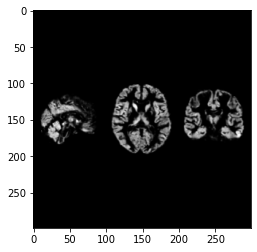

In [19]:
ix = 20
print(images_tf[ix].shape)
plt.imshow(images_tf[ix]*0.5+0.5)

In [20]:
# create 2D mask so we can extract brain pixels
av = images_tf[:,:,:,0].numpy().mean(axis=0)
mask_2d = (av>-0.8)

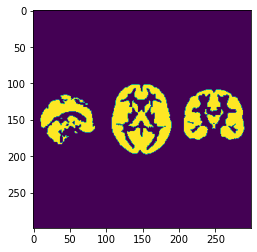

In [21]:
plt.imshow(mask_2d)

<a id="correlation"></a>
# Correlation
[back to top](#top)

Calculate within-iteration correlation and correlation between iteration and real data.

In [ ]:
images = images_tf.numpy()

im=images[:,:,:,0].reshape((240, -1))
im1=im[:100,:]
im2=im[100:,:]
im1.shape, im2.shape

In [ ]:
plt.imshow(np.corrcoef(im1, im2))

In [ ]:
C = np.zeros((n_images, mask_2d.sum()))
C.shape

# vectorize images
for ix in range(n_images):
    C[ix,:] = images[ix, :, :, 0][mask_2d]
    
# covariance matrix
C = np.corrcoef(C, rowvar=True)

# extract lower triangular part of the matrix
mask = np.triu(np.ones_like(C, dtype=np.bool), -1)
C[mask] = np.nan

In [ ]:
plt.rcParams['figure.figsize']=(10,6)
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
#     plt.Figure(figsize=(12,12))
    sns.set_style("whitegrid")
    heatmap = sns.heatmap(C, cmap='coolwarm', robust=True, \
               cbar_kws={'orientation': 'vertical'})
    ticks = [0, 32, 64, 96, 128, 160, 240]
    heatmap.set_yticks(ticks)
    heatmap.set_xticks(ticks)

plt.savefig(figdir + 'gan_correlation_matrix.png', dpi=200, bbox_inches='tight')

In [ ]:
# within-iteration correlations
df_within = []
for t in range(len(ticks)-1):
    vals = C[ticks[t]:ticks[t+1], ticks[t]:ticks[t+1]]
    vals = vals[~np.isnan(vals)]
    tmp = pd.DataFrame({'correlation':vals})
    tmp['iteration'] = t
    df_within.append(tmp)

df_within = pd.concat(df_within, axis=0)
df_within['iteration'] = df_within.iteration.astype('category')
df_within['iteration'] = df_within.iteration.cat.reorder_categories([1,2,3,4,5,0]).cat.rename_categories({0:'real', 1:344, 2:1055, 3:7954, 4:24440, 5:60000})

In [ ]:
plt.rcParams['figure.figsize']=(3,6)
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
#     plt.Figure(figsize=(12,12))
    sns.set_style("whitegrid")
    ax = sns.barplot(y='iteration', x='correlation', palette="magma", \
                     orient='h', data=df_within)
    plt.xlim([0.7, 0.9])
    plt.title('Within-iteration correlation')
    sns.despine(ax=ax, offset=3)
    plt.savefig(figdir + 'gan_within-iteration_correlation.png', dpi=200, bbox_inches='tight')

# ranksum tests
wilcoxon_ranksum(df_within, 'correlation')
print('24440 vs 60000:', stats.ranksums(df_within[df_within.iteration == 24440].correlation, \
                        df_within[df_within.iteration == 60000].correlation))
print('60000 vs real:', stats.ranksums(df_within[df_within.iteration == 60000].correlation, \
                        df_within[df_within.iteration == 'real'].correlation))
print('MEAN:', df_within.groupby('iteration')['correlation'].mean())
print('STD:', df_within.groupby('iteration')['correlation'].std())

In [ ]:
stat = wilcoxon_ranksum(df_within, 'correlation', stat=stat, do_print=True)
stat

In [ ]:
# iteration vs real correlations
df_between = []
for t in range(1, len(ticks)-1):
    vals = C[ticks[t]:ticks[t+1], 0:80]
    vals = vals[~np.isnan(vals)]
    tmp = pd.DataFrame({'correlation':vals})
    tmp['iteration'] = t
    df_between.append(tmp)

df_between = pd.concat(df_between, axis=0)
df_between['iteration'] = df_between.iteration.astype('category')
df_between['iteration'] = df_between.iteration.cat.rename_categories({1:344, 2:1055, 3:7954, 4:24440, 5:60000})

df_between.head()  

In [ ]:
plt.rcParams['figure.figsize']=(7,3)
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y='correlation', palette="magma", data=df_between)
    plt.ylim([0.6, 0.9]); ax.set_yticks([0.6, 0.7, 0.8])
    plt.title('Real-vs-iteration correlation')
#     plt.ylim([0.75, 0.8])
    sns.despine(ax=ax, offset=3)
    plt.savefig(figdir + 'gan_real-vs-iteration_correlation.png', dpi=200, bbox_inches='tight')    

    
print('24440 vs 60000:', stats.ranksums(df_between[df_between.iteration == 24440].correlation, \
                        df_between[df_between.iteration == 60000].correlation))
print('MEAN:', df_between.groupby('iteration')['correlation'].mean())
print('STD:', df_between.groupby('iteration')['correlation'].std())

----

<a id="metrics"></a>
# Metrics

----

<a id="inception"></a>
# Inception score
[back to top](#top)

In [63]:
def calculate_inception_score(pred_softmax, do_average=True, do_exp=True, eps=1E-16):
    '''
    Args:
        pred_softmax - softmax predictions
    '''
    p_yx = pred_softmax
    
    # calculate p(y)
    p_y = np.expand_dims(p_yx.mean(axis=0), axis=0)
    
    # kl divergence for each image
    kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
    
    # sum over classes
    sum_kl_d = kl_d.sum(axis=1)
  
    if do_average: sum_kl_d = sum_kl_d.mean()
    
    is_score = np.exp(sum_kl_d) if do_exp else sum_kl_d
    return is_score

In [64]:
# load inception model
inception_model = tf.keras.applications.InceptionV3(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

In [65]:
# calculate predictions for all images
pred_softmax = inception_model.predict(images_tf, batch_size=16)
pred_softmax.shape

(30, 1000)

In [66]:
real_ix = (df_images['iteration'] == 'real').to_numpy().nonzero()[0][[0,-1]]
real_pred = pred_softmax[real_ix[0]:real_ix[1]+1,:]
df_is = []

for it in iterations:
    print('processing iteration', it)
    # find start and end index of images corresponding to this iteration
    gan_ix = (df_images['iteration'] == str(it)).to_numpy().nonzero()[0][[0,-1]]
    gan_pred = pred_softmax[gan_ix[0]:gan_ix[1]+1,:]
    IS = calculate_inception_score(gan_pred, do_average=False)
    tmp = pd.DataFrame({'IS':IS, 'iteration':it})
#     IS = bootstrap1(gan_pred, calculate_inception_score, n_bootstrap=n_bootstrap)
#     tmp = pd.DataFrame({'bootstrap':range(n_bootstrap), 'IS':IS, 'iteration':it})
    df_is.append(tmp)

# IS for real images
df_is.append(pd.DataFrame({'IS':calculate_inception_score(real_pred,False),'iteration':'real'}))
# df_is.append(pd.DataFrame({'bootstrap':range(n_bootstrap),'IS':bootstrap1(real_pred, calculate_inception_score, n_bootstrap=n_bootstrap),'iteration':'real'}))

df_is = pd.concat(df_is, axis=0)
df_is['iteration'] = df_is['iteration'].astype('category')
df_is.dtypes

processing iteration 344
processing iteration 1055
processing iteration 7954
processing iteration 24440
processing iteration 60000


IS            float32
iteration    category
dtype: object

In [70]:
df_is.shape

(30, 2)

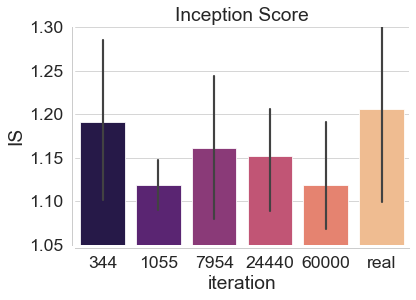

In [71]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y='IS', palette="magma", data=df_is)
#     plt.ylabel('IS')
    plt.title('Inception Score')
    if task=='detection': plt.ylim([1.05, 1.6])
    if task=='rating': plt.ylim([1.05, 1.3])
    sns.despine(ax=ax, offset=3)
    plt.savefig(figdir + f'{task}_metrics_IS.png', dpi=200, bbox_inches='tight')

In [72]:
stat = wilcoxon_ranksum(df_is, 'IS', stat, do_print=False)
stat

IS is already present, replacing


,metric,iteration,iteration2,p,z
0,IS,344.0,1055,0.347208,0.940019
1,IS,1055.0,7954,0.601508,-0.522233
2,IS,7954.0,24440,0.754023,0.313340
3,IS,24440.0,60000,0.464702,0.731126
4,IS,60000.0,real,0.250592,-1.148913


In [73]:
# rank correlation: iteration vs metric
tmp = df_is[df_is.iteration != 'real']
print('iteration-metric rank correlation:', stats.spearmanr(tmp['iteration'], tmp['IS']))
print('iteration 60000 vs real:', stats.ranksums(df_is[df_is.iteration==60000].IS, df_is[df_is.iteration=='real'].IS))

iteration-metric rank correlation: SpearmanrResult(correlation=-0.14904826270501986, pvalue=0.4770377864859081)
iteration 60000 vs real: RanksumsResult(statistic=-1.1489125293076057, pvalue=0.25059205068568424)


In [74]:
tmp = df_is[df_is.iteration != 'real']
linear_regression(tmp['IS'], tmp['iteration'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     -0.016   
Dependent Variable: IS               AIC:                -49.0883 
Date:               2022-01-29 19:42 BIC:                -46.6506 
No. Observations:   25               Log-Likelihood:     26.544   
Df Model:           1                F-statistic:        0.6110   
Df Residuals:       23               Prob (F-statistic): 0.442    
R-squared:          0.026            Scale:              0.0076120
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
x1          -0.0071     0.0091   -0.7817   0.4424   -0.0259   0.0117
const        1.2091     0.0798   15.1522   0.0000    1.0441   1.3742
------------------------------------------------------------------
Omnibus:               2.155        Durbin-Watson:           2.367
Pro

----

<a id="modified_inception"></a>
# Modified Inception score
[back to top](#top)

In [75]:
def calculate_modified_inception_score(pred_softmax, do_exp=True, eps=1E-16):
    p_yx = pred_softmax
    
    # predicted classes
    class_labels = pred_softmax.argmax(axis=1)

    # calculate modified score per class
    kl_d = []
#     print('classes:', np.unique(class_labels))
    for c in np.unique(class_labels): # -- per class -- 
        p_yx_c = p_yx[class_labels == c,:]
#         print('class c:', p_yx_c.shape)
        kls = []
        for ix1 in range(p_yx_c.shape[0]):
            kl2 = []
            for ix2 in range(p_yx_c.shape[0]):
                if ix1==ix2: continue
                kl = p_yx_c[ix1,:] * ( np.log(p_yx_c[ix1,:] + eps) - np.log(p_yx_c[ix2,:] + eps) )
                kl2.append(kl.sum())
            if len(kl2)>0: kls.append(sum(kl2)/len(kl2))
    
        # append within-class mean
        if len(kls)>1: kl_d.append(sum(kls)/len(kls))

#     print('kl_d:', len(kl_d))
    kl_d = sum(kl_d)/len(kl_d)
#     kl_d = sum(kl_d)
    
    mis_score = np.exp(kl_d) if do_exp else kl_d
    return mis_score #, class_labels

In [76]:
# load inception model
inception_model = tf.keras.applications.InceptionV3(
    include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

In [77]:
# calculate predictions for all images
pred_softmax = inception_model.predict(images_tf, batch_size=16)

In [78]:
df_mis = []

for it in iterations + ['real'] :
    print('processing iteration', it)
    # find start and end index of images corresponding to this iteration
    im_ix = (df_images['iteration'] == str(it)).to_numpy().nonzero()[0][[0,-1]]
    mis = bootstrap1(pred_softmax[im_ix[0]:im_ix[1]+1,:], calculate_modified_inception_score, n_bootstrap)
    tmp = pd.DataFrame({'bootstrap':range(n_bootstrap), 'MIS':mis})
    tmp['iteration'] = it
    df_mis.append(tmp)
    
df_mis = pd.concat(df_mis, axis=0)

processing iteration 344
processing iteration 1055
processing iteration 7954
processing iteration 24440
processing iteration 60000
processing iteration real


iteration 60000 vs Real: RanksumsResult(statistic=2.6119827203378057, pvalue=0.00900188038949093)


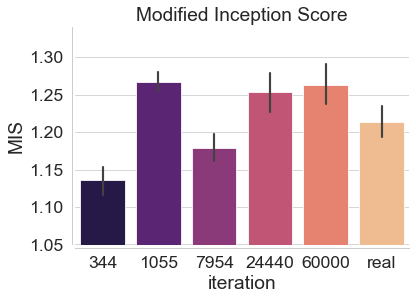

In [80]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y='MIS', palette="magma", data=df_mis)
    plt.title('Modified Inception Score')
    if task=='detection': plt.ylim((1.05, 1.55))
    if task=='rating': plt.ylim((1.05, 1.34))
    sns.despine(ax=ax, offset=3)
    plt.savefig(figdir + f'{task}_metrics_MIS.png', dpi=200, bbox_inches='tight')
    
print('iteration 60000 vs Real:', stats.ranksums(df_mis[df_mis.iteration == 60000]['MIS'],df_mis[df_mis.iteration == 'real']['MIS']))

In [81]:
# rank correlation: iteration vs metric
tmp = df_mis[df_mis.iteration != 'real']
print('iteration-metric rank correlation:', stats.spearmanr(tmp['iteration'], tmp['MIS']))
print('iteration 60000 vs real:', stats.ranksums(df_mis[df_mis.iteration==60000].MIS, df_mis[df_mis.iteration=='real'].MIS))

iteration-metric rank correlation: SpearmanrResult(correlation=0.2690219226408602, pvalue=9.745781907281526e-10)
iteration 60000 vs real: RanksumsResult(statistic=2.6119827203378057, pvalue=0.00900188038949093)


In [82]:
tmp = df_mis[df_mis.iteration != 'real']
linear_regression(tmp['MIS'], tmp['iteration'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.063    
Dependent Variable: MIS              AIC:                -732.4782
Date:               2022-01-29 19:44 BIC:                -724.0490
No. Observations:   500              Log-Likelihood:     368.24   
Df Model:           1                F-statistic:        34.64    
Df Residuals:       498              Prob (F-statistic): 7.28e-09 
R-squared:          0.065            Scale:              0.013476 
---------------------------------------------------------------------
          Coef.     Std.Err.       t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
x1        0.0159      0.0027     5.8858    0.0000    0.0106    0.0212
const     1.0829      0.0237    45.6126    0.0000    1.0363    1.1296
------------------------------------------------------------------
Omnibus:               77.682       Durbin-Watson:          1.739

---


<a id="frechet"></a>
# Frechet Inception Distance
[back to top](#top)

based on https://github.com/bioinf-jku/TTUR/blob/master/fid.py


In [83]:
# based on: https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [84]:
# load inception model without last layer
inception_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling='avg', classes=1000
)

In [85]:
# calculate predictions for all images
pred = inception_model.predict(images_tf, batch_size=16)
pred.shape

(30, 2048)

In [86]:
real_ix = (df_images['iteration'] == 'real').to_numpy().nonzero()[0][[0,-1]]
act1 = pred[real_ix[0]:real_ix[1]+1,:]
df_fid = []

for it in iterations:
    print('processing iteration', it)
    # find start and end index of images corresponding to this iteration
    gan_ix = (df_images['iteration'] == str(it)).to_numpy().nonzero()[0][[0,-1]]
    act2 = pred[gan_ix[0]:gan_ix[1]+1,:]
    fid = bootstrap2(act1, act2, calculate_fid, n_bootstrap)
    tmp = pd.DataFrame({'bootstrap':range(n_bootstrap), 'FID':fid})
    tmp['iteration'] = it
    df_fid.append(tmp)
    
df_fid = pd.concat(df_fid, axis=0)

processing iteration 344
processing iteration 1055
processing iteration 7954
processing iteration 24440
processing iteration 60000


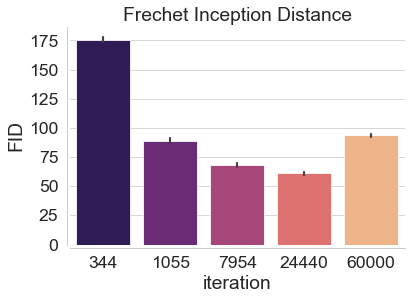

In [87]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y='FID', palette="magma", data=df_fid)
#     plt.ylim([20, 160]); ax.set_yticks(range(20, 160, 20))
    plt.title('Frechet Inception Distance')
    sns.despine(ax=ax, offset=3)
    plt.savefig(figdir + f'{task}_metrics_FID.png', dpi=200, bbox_inches='tight')

In [88]:
# rank correlation: iteration vs metric
tmp = df_fid[df_fid.iteration != 'real']
print('iteration-metric rank correlation:', stats.spearmanr(tmp['iteration'], tmp['FID']))
print('iteration 60000 vs 24440:', stats.ranksums(df_fid[df_fid.iteration==60000].FID, df_fid[df_fid.iteration==24440].FID))

iteration-metric rank correlation: SpearmanrResult(correlation=-0.4621706490105525, pvalue=7.946236754662873e-28)
iteration 60000 vs 24440: RanksumsResult(statistic=12.209614268969144, pvalue=2.7619548486352597e-34)


In [89]:
# linear regression
tmp = df_fid[df_fid.iteration != 'real']
linear_regression(tmp['FID'], tmp['iteration'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.474    
Dependent Variable: FID              AIC:                4833.7880
Date:               2022-01-29 20:47 BIC:                4842.2172
No. Observations:   500              Log-Likelihood:     -2414.9  
Df Model:           1                F-statistic:        450.1    
Df Residuals:       498              Prob (F-statistic): 1.21e-71 
R-squared:          0.475            Scale:              921.23   
-------------------------------------------------------------------
            Coef.    Std.Err.     t      P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
x1         -14.9819    0.7062  -21.2163  0.0000  -16.3693  -13.5945
const      226.0073    6.2075   36.4087  0.0000  213.8112  238.2034
------------------------------------------------------------------
Omnibus:             9032.172       Durbin-Watson:          0.187 
Prob(Omn

---


<a id="mmd"></a>
# Maximum Mean Discrepancy (MMD)
[back to top](#top)

In [90]:
def calculate_mmd(im1, im2):
    '''
    im1, im2: (n_samples, n_features) matrices of images
    '''
    from sklearn.metrics.pairwise import rbf_kernel
    n1 = im1.shape[0]
    mmd = rbf_kernel(im1,im1).sum() + rbf_kernel(im2,im2).sum() - 2*rbf_kernel(im1,im2).sum()
    
    return mmd

In [91]:
# load inception model without last layer
inception_model = tf.keras.applications.InceptionV3(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=None, pooling='avg', classes=1000
)

In [92]:
# calculate VGG predictions for all images
pred = inception_model.predict(images_tf, batch_size=16)

In [93]:
# alternatively, extract pixels directly using a brain mask
# im_pixels = np.zeros((n_images, mask_2d.sum()))

# for n in range(n_images):
#     im_pixels[n, :] = images_tf.numpy()[n, :, :, 0][mask_2d]

In [94]:
real_ix = (df_images['iteration'] == 'real').to_numpy().nonzero()[0][[0,-1]]
real_pred = pred[real_ix[0]:real_ix[1]+1,:]
df_mmd = []

for it in iterations:
    print('processing iteration', it)
    # find start and end index of images corresponding to this iteration
    gan_ix = (df_images['iteration'] == str(it)).to_numpy().nonzero()[0][[0,-1]]
    gan_pred = pred[gan_ix[0]:gan_ix[1]+1,:]
#     gan_pixels = im_pixels[gan_ix[0]:gan_ix[1]+1,:]
    mmd_pred = bootstrap2(real_pred, gan_pred, calculate_mmd, n_bootstrap=n_bootstrap)
    tmp  = pd.DataFrame({'bootstrap':range(n_bootstrap), 'MMD':mmd_pred, 'iteration':it, 'features':'VGG'})
    df_mmd.append(tmp)
#     mmd_pixels = bootstrap2(im_pixels[real_ix[0]:real_ix[1]+1,:], gan_pixels, calculate_mmd, n_bootstrap=n_bootstrap)
#     tmp2 = pd.DataFrame({'bootstrap':range(n_bootstrap), 'MMD':mmd_pixels, 'iteration':it, 'features':'pixels'})
#     df_mmd.extend([tmp,tmp2])
    
df_mmd = pd.concat(df_mmd, axis=0)

processing iteration 344
processing iteration 1055
processing iteration 7954
processing iteration 24440
processing iteration 60000


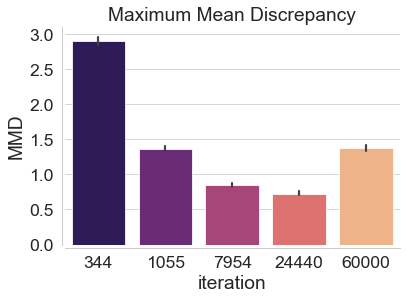

In [95]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y='MMD', palette="magma", data=df_mmd)
#     ax = sns.barplot(x='iteration', y='MMD', palette="magma", hue='features', data=df_mmd)
    plt.title('Maximum Mean Discrepancy')
    sns.despine(ax=ax, offset=3)
#     ax.set_yticks([2200, 2300, 2400, 2500, 2600])
    if task=='detection': plt.ylim([2220, 2530])
    plt.savefig(figdir + f'{task}_metrics_MMD.png', dpi=200, bbox_inches='tight')

# print('VGG features:')
# df = df_mmd[df_mmd.features == 'VGG']
# print('iteration 344 vs 1055:', stats.ranksums(df[df.iteration == 344]['MMD'],df[df.iteration == 1055]['MMD']))    
# print('iteration 7954 vs 24440:', stats.ranksums(df[df.iteration == 7954]['MMD'],df[df.iteration == 24440]['MMD']))    
# print('iteration 24440 vs 60000:', stats.ranksums(df[df.iteration == 24440]['MMD'],df[df.iteration == 60000]['MMD']))    

# print('pixels features:')
# df = df_mmd[df_mmd.features == 'pixels']
# print('Batch 344 vs 1055:', stats.ranksums(df[df.batch == 344]['MMD'],df[df.batch == 1055]['MMD']))    
# print('Batch 7954 vs 24440:', stats.ranksums(df[df.batch == 7954]['MMD'],df[df.batch == 24440]['MMD']))    
# print('Batch 24440 vs 60000:', stats.ranksums(df[df.batch == 24440]['MMD'],df[df.batch == 60000]['MMD']))    

In [96]:
# stat = wilcoxon_ranksum(df_mmd[df_mmd.features=='VGG'], 'MMD', stat, appendix='_VGG', do_print=False)
# stat = wilcoxon_ranksum(df_mmd[df_mmd.features=='pixels'], 'MMD', stat, appendix='_pixels', do_print=False, do_remove=False)
# stat.tail(10)

In [97]:
# rank correlation: batch vs metric
# rank correlation: iteration vs metric
print('iteration 60000 vs 24440:', stats.ranksums(df_mmd[df_mmd.iteration==60000].MMD, df_mmd[df_mmd.iteration==24440].MMD))
print('iteration-metric rank correlation:', stats.spearmanr(df_mmd['iteration'], df_mmd['MMD']))

iteration 60000 vs 24440: RanksumsResult(statistic=12.001926213563426, pvalue=3.471224731335013e-33)
iteration-metric rank correlation: SpearmanrResult(correlation=-0.5145212484946182, pvalue=3.839527710002258e-35)


In [98]:
# linear regression
tmp = df_mmd[df_mmd.iteration != 'real']
linear_regression(tmp['MMD'], tmp['iteration'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.485   
Dependent Variable: MMD              AIC:                868.3188
Date:               2022-01-29 20:48 BIC:                876.7480
No. Observations:   500              Log-Likelihood:     -432.16 
Df Model:           1                F-statistic:        470.8   
Df Residuals:       498              Prob (F-statistic): 5.63e-74
R-squared:          0.486            Scale:              0.33113 
-------------------------------------------------------------------
          Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
-------------------------------------------------------------------
x1       -0.2905     0.0134   -21.6971   0.0000   -0.3168   -0.2642
const     3.9378     0.1177    33.4597   0.0000    3.7066    4.1691
-----------------------------------------------------------------
Omnibus:             366.589       Durbin-Watson:          0.270 
Prob(Omnibus):   

---

<a id="vmaf"></a>
# VMAF
[back to top](#top)

For VMAF, images need to be converted. We pad the images to 480 x 360 (360p) and save them as `.yuv` format.

In [ ]:
# Load images
images = np.zeros((n_images, 135, 355, 3))

for index, row in df_images.iterrows():
    im = np.array(PIL.Image.open(imagedir + row['image'] + '.png'))[:,:,:3]
    im = im[75:210,45:400]  # cut away the empty area around the MRI
    images[index, :, :, :] = im
    
im_h, im_w = im.shape[:2]
print('Image:', im_w, 'x', im_h)

In [ ]:
# Pad images
w, h = 480, 360 # 360p
images_tf = tf.image.pad_to_bounding_box(images, offset_width=(w - im_w)//2, \
                             offset_height=(h - im_h)//2, 
                            target_height=h, target_width=w)

In [ ]:
# Save padded images in 360p folder
for index, row in df_images.iterrows():
    filename = imagedir + 'images_vmaf_360p/' + row['image'] + '.png'
    tf.keras.preprocessing.image.save_img(filename, images_tf[index,:,:,:])

In [ ]:
# -- Requires the FFMEG command line tool --
# Convert PNG to YUV (yuv420p = 8-bit encoding)
# https://sh-tsang.medium.com/tutorial-converting-png-to-yuv-using-ffmpeg-or-opencv-c-api-a65f387609ad
# In the BASH run this:
# for f in `ls *png`; do echo "$f -> ${f%.png}.yuv"; ffmpeg -i $f -pix_fmt yuv420p ../images_vmaf_yuv/${f%.png}.yuv; done

In [ ]:
# -- Requires the VMAF command line tool --
# https://github.com/Netflix/vmaf/blob/master/libvmaf/tools/README.md
# We run a double loop in the bash, looping across all combinations of real and generated images
# The first loop is for real images, the second loop for generated ones
# Each time the VMAF and other metrics (psnr, ssim, ms-ssim) are stored in a csv file
# In the BASH run this:


In [99]:
# -- LOADING RESULTS --
# load VMAF from CSV files and store in single dataframe
df_vmaf = []
for it in iterations:
    if task == 'detection':
        files = glob(imagedir + f'images_vmaf_yuv/real*_batch_{it}_im*.csv')
    elif task == 'rating':
        files = glob(imagedir + f'images_vmaf_yuv_rating/real*_batch_{it}_im*.csv')
    print(f'{len(files)} csv files found in iteration {it}')
    for file in files:
        df = pd.read_csv(file)
        df = df[['psnr_y', 'float_ssim', 'float_ms_ssim', 'vmaf']]
        df['iteration'] = it
        df_vmaf.append(df)

df_vmaf = pd.concat(df_vmaf, axis=0)

25 csv files found in iteration 344
25 csv files found in iteration 1055
25 csv files found in iteration 7954
25 csv files found in iteration 24440
25 csv files found in iteration 60000


In [100]:
df_vmaf = df_vmaf.rename(columns={'psnr_y':'PSNR', 'float_ssim':'SSIM','float_ms_ssim':'MS-SSIM', 
                       'vmaf':'VMAF'})

In [ ]:
metric = 'PSNR'
metric = 'MS-SSIM'
metric = 'SSIM'
metric = 'VMAF'
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y=metric, palette="magma", data=df_vmaf)
#     plt.ylim([2200, 2600]); ax.set_yticks([2200, 2300, 2400, 2500, 2600])
    plt.title(metric)
#     ax.add_line(Line2D([3.1,3.1,3.9,3.9], [30,35,35,30], color='k'))
#     yl = plt.ylim()
#     plt.ylim((yl[0], yl[1]+5))
    if metric == 'PSNR': plt.ylim((22.1, 25.55))
    elif metric == 'MS-SSIM': plt.ylim((0.925, 0.967))
    elif metric == 'SSIM': plt.ylim((0.9, 0.949))
    elif metric == 'VMAF': plt.ylim((6, 33.5))
    sns.despine(ax=ax, offset=3)
    plt.savefig(figdir + f'{task}_metrics_{metric}.png', dpi=200, bbox_inches='tight')

In [85]:
df_vmaf

,PSNR,SSIM,MS-SSIM,VMAF,iteration
0,22.939062,0.898402,0.927079,8.313706,344
0,22.826765,0.897073,0.925639,4.179038,344
0,22.878671,0.901677,0.929180,8.539895,344
0,23.115397,0.901604,0.931775,4.534668,344
0,23.174731,0.905555,0.935566,6.029225,344
...,...,...,...,...,...
0,24.599063,0.948164,0.964188,39.973807,60000
0,24.315822,0.942176,0.958450,31.586167,60000
0,25.344360,0.949060,0.967620,37.412873,60000
0,26.004700,0.949302,0.971863,32.252959,60000


In [101]:
# linear regression
for m in ('PSNR', 'MS-SSIM', 'SSIM', 'VMAF'):
    print('---', m, '---')
    linear_regression(df_vmaf[m], df_vmaf['iteration'])

--- PSNR ---
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.315   
Dependent Variable: PSNR             AIC:                330.0642
Date:               2022-01-29 20:48 BIC:                335.7208
No. Observations:   125              Log-Likelihood:     -163.03 
Df Model:           1                F-statistic:        58.15   
Df Residuals:       123              Prob (F-statistic): 5.70e-12
R-squared:          0.321            Scale:              0.80797 
-------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
x1         0.3189     0.0418    7.6255   0.0000    0.2361    0.4017
const     21.8330     0.3677   59.3817   0.0000   21.1052   22.5608
-----------------------------------------------------------------
Omnibus:               0.534        Durbin-Watson:          1.776
Prob

In [102]:
# Wilcoxon rank-sum
for m in ('PSNR', 'MS-SSIM', 'SSIM', 'VMAF'):
    print('---', m, '---')
    print('iteration 60000 vs 24440:', stats.ranksums(df_vmaf[df_vmaf.iteration==60000][m], df_vmaf[df_vmaf.iteration==24440][m]))

--- PSNR ---
iteration 60000 vs 24440: RanksumsResult(statistic=0.1455213750217998, pvalue=0.8842992405514215)
--- MS-SSIM ---
iteration 60000 vs 24440: RanksumsResult(statistic=-0.41716127506249273, pvalue=0.6765604481507999)
--- SSIM ---
iteration 60000 vs 24440: RanksumsResult(statistic=-0.669398325100279, pvalue=0.5032414197587344)
--- VMAF ---
iteration 60000 vs 24440: RanksumsResult(statistic=1.096261025164225, pvalue=0.2729645604132478)


---

<a id="niqe"></a>
# NIQE/BRISQUE
[back to top](#top)

Load results created with Matlab script `analyze_2D_image_NIQE_BRISQUE.m`

In [103]:
nb_detection = pd.read_csv(resultdir + 'analyze_2D_image_NIQE_BRISQUE_detection.csv')
nb_rating = pd.read_csv(resultdir + 'analyze_2D_image_NIQE_BRISQUE_rating.csv')

nb_detection['iteration'] = nb_detection.batch.astype('category')
nb_detection['iteration'] = nb_detection.iteration.cat.reorder_categories([1,2,3,4,5,0]).cat.rename_categories({0:'real', 1:'344', 2:'1055', 3:'7954', 4:'24440', 5:'60000'})
nb_rating['iteration'] = nb_rating.batch.astype('category')
nb_rating['iteration'] = nb_rating.iteration.cat.reorder_categories([1,2,3,4,5,0]).cat.rename_categories({0:'real', 1:'344', 2:'1055', 3:'7954', 4:'24440', 5:'60000'})

nb_rating.head()

,image,batch,niqe,brisque,niqe-mri,brisque-mri,iteration
0,batch_344_im_201,1,17.043516,38.901735,19.627273,3.617705,344
1,batch_344_im_202,1,17.188457,36.958013,18.486816,3.815763,344
2,batch_344_im_203,1,14.409123,39.830189,17.892989,4.055648,344
3,batch_344_im_204,1,17.471897,37.539808,20.224067,3.469986,344
4,batch_344_im_205,1,16.490783,37.615966,20.083859,3.616220,344


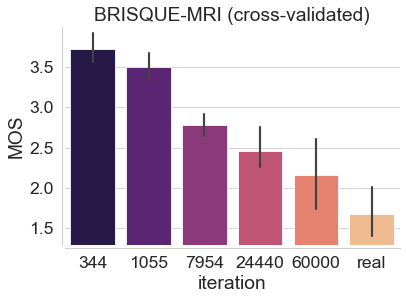

In [104]:
m = 'niqe'
# m = 'brisque'
# m = 'niqe-mri'
m = 'brisque-mri'
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    if task == 'detection':
        ax = sns.barplot(x='iteration', y=m, palette="magma", data=nb_detection)
    else:
        ax = sns.barplot(x='iteration', y=m, palette="magma", data=nb_rating)
    plt.title(m.upper())
    sns.despine(ax=ax, offset=3)
#     ax.set_yticks([2200, 2300, 2400, 2500, 2600])
    if task=='detection':
        if m=='niqe': plt.ylim([12, 17.1]) # nique - detection
        if m=='brisque': plt.ylim([1.81, 2.22]) # brisque - detection
        if m=='niqe-mri': plt.ylim([12.1, 19.8]) # nique-mri - detection
        if m=='brisque-mri': plt.ylim([1.1, 3.7]) # brisque-mri - detection
    elif task=='rating':
        if m=='niqe': plt.ylim([12, 17.2]) # nique - detection
        if m=='brisque': plt.ylim([1.81, 2.19]) # brisque - detection
        if m=='niqe-mri': plt.ylim([12.1, 19.99]) # nique-mri - detection
        if m=='brisque-mri': 
            plt.ylim([1.3, 3.99]) # brisque-mri - detection
            plt.title('BRISQUE-MRI (cross-validated)')
    if 'brisque' in m: plt.ylabel('MOS')
    plt.savefig(figdir + f'{task}_metrics_{m}.png', dpi=200, bbox_inches='tight')


In [105]:
df = nb_rating[nb_rating.iteration!='real'] if task == 'rating' else nb_detection[nb_detection.iteration!='real']

# linear regression
for m in ('niqe', 'niqe-mri', 'brisque', 'brisque-mri'):
    print('---', m, '---')
    linear_regression(df[m], df['iteration'])

--- niqe ---
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.780   
Dependent Variable: niqe             AIC:                67.1205 
Date:               2022-01-29 20:48 BIC:                69.5583 
No. Observations:   25               Log-Likelihood:     -31.560 
Df Model:           1                F-statistic:        86.26   
Df Residuals:       23               Prob (F-statistic): 3.03e-09
R-squared:          0.789            Scale:              0.79479 
-------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
-------------------------------------------------------------------
x1        -0.8615     0.0928   -9.2875   0.0000   -1.0534   -0.6696
const     21.7678     0.8154   26.6956   0.0000   20.0810   23.4546
-----------------------------------------------------------------
Omnibus:               1.803        Durbin-Watson:          1.572
Prob

In [106]:
df = nb_rating if task == 'rating' else nb_detection

# Wilcoxon rank-sum
for m in ('niqe', 'niqe-mri', 'brisque', 'brisque-mri'):
    print('---', m, '---')    
    print('iteration 60000 vs real:', stats.ranksums(df[df.iteration=='60000'][m], df[df.iteration=='real'][m]))

--- niqe ---
iteration 60000 vs real: RanksumsResult(statistic=-1.3578057164544433, pvalue=0.17452534056858338)
--- niqe-mri ---
iteration 60000 vs real: RanksumsResult(statistic=2.40227165218863, pvalue=0.016293603621028527)
--- brisque ---
iteration 60000 vs real: RanksumsResult(statistic=0.5222329678670935, pvalue=0.6015081344405899)
--- brisque-mri ---
iteration 60000 vs real: RanksumsResult(statistic=1.5666989036012806, pvalue=0.11718508719813801)


---

<a id="load_save"></a>
# Load/save metrics
[back to top](#top)

In [ ]:
# Load data
with open(resultdir + f'analyze_gan_2D_all_metrics_{task}.pickle', 'rb') as f:
    (df_is, df_mis, df_fid, df_mmd, df_vmaf, stat) = pickle.load(f)

In [107]:
# Save data
with open(resultdir + f'analyze_gan_2D_all_metrics_{task}.pickle', 'wb') as f:
    pickle.dump((df_is, df_mis, df_fid, df_mmd, df_vmaf, stat), f, protocol=pickle.HIGHEST_PROTOCOL)

<a id="deepqa"></a>
# Deep QA model
[back to top](#top)

In [ ]:
def clean_RT_data(df, RT_col, low_RT, high_RT, n_timeouts = None):
    '''Cleans RT data by removing too short RTs and removing participants with
    too many timeouts'''
    # time outs
    if n_timeouts is not None:
        timeout = df.groupby('participant')['timeout'].sum()
        timeout = timeout[timeout > n_timeouts]
        if timeout.shape[0] > 0:
            print(f'{timeout.shape[0]} participants have >{n_timeouts} timeouts, removing them')
            for ix in timeout.index:
                df = df[df['participant'] != ix]

    # check lower RT bound
    df_low = df[df[RT_col] <= low_RT]
    if df_low.shape[0] > 0:
        print(f'Removing {df_low.shape[0]} trials with RT <= {low_RT}')
        df = df[df[RT_col] > low_RT]

    # check high RT bound
    df_high = df[df[RT_col] >= high_RT]
    if df_high.shape[0] > 0:
        print(f'Removing {df_high.shape[0]} trials with RT >= {high_RT}')
        df = df[df[RT_col] < high_RT]

    return df

In [ ]:
# Empirical distribution 
with open(resultdir + f'psytoolkit_all_participants26.pickle', 'rb') as f:
    df_rating = pickle.load(f)

# select only rating task
df_rating = df_rating[df_rating.task == 'RATING_TASK']

# clean RTs like in analyze_toolkit_data
df_rating = clean_RT_data(df_rating, 'rate_RT', low_RT=150, high_RT=10000)

# dummy code rating
df_rating = pd.concat((df_rating, pd.get_dummies(df_rating.rate, prefix='rate')), axis=1)
df_rating['batch'] = df_rating['batch'].replace({344:0, 1055:1, 7954:2, 24440:3, 60000:4, 'real':5}).astype('int')

# calculate empirical posterior pobabilities for each of the 30 images by averaging each rate across participants
p_yx = df_rating.groupby('tablerow').apply(lambda x:
                pd.Series({'batch':np.unique(x.batch)[0], 'rate':x.rate.mean(),
                          'rate_1':x['rate_1'].mean(),'rate_2':x['rate_2'].mean(),'rate_3':x['rate_3'].mean(),
                          'rate_4':x['rate_4'].mean(),'rate_5':x['rate_5'].mean()})).reset_index().copy()
print(p_yx.shape)
p_yx.batch = p_yx.batch.astype('int')
p_yx.groupby('batch').mean().loc[:,'rate_1':]

In [ ]:
p_yx.groupby('batch').mean().loc[:,'rate_1':].plot(kind='bar')
plt.title('Empirical distribution of rate')

In [ ]:
pretrained = 'none'
# pretrained = 'densenet201'
# pretrained = 'resnet101'
pretrained = 'inceptionv3'

detection_task = 'multiclass'

with open(resultdir + f'results_DeepQA_{pretrained}_{detection_task}_rating_hist.pickle', 'rb') as f:
    rating_hist, bayes_accuracy = pickle.load(f)

print('Bayes accuracy:', bayes_accuracy)
sh = rating_hist.shape

In [ ]:
# RATING HIST: to convert numpy array to Pandas dataframe, define the dimensions and create multi-index
iterables=[range(sh[0]), range(sh[1]), range(sh[2]), ('loss','train acc','test acc')]
index = pd.MultiIndex.from_product(iterables, names=['run','fold','epoch','metric'])

rating_hist = pd.DataFrame(rating_hist.reshape(-1,1), index, columns=['value']).reset_index()
print(rating_hist.shape)
rating_hist.head()

In [ ]:
detection_hist = pd.read_csv(resultdir + f'results_DeepQA_{pretrained}_{detection_task}_detection_hist.csv')
rating_pred = pd.read_csv(resultdir + f'results_DeepQA_{pretrained}_{detection_task}_rating_pred.csv')

# convert batch to category and rename values
rating_pred['batch'] = rating_pred['batch'].astype('category').cat.rename_categories({5:'real', 0:344, 1:1055, 2:7954, 3:24440, 4:60000})

In [ ]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")

    # Loss
    ax = sns.lineplot(x='index', y='loss', palette="magma", data=detection_hist)
    ax = sns.lineplot(x='index', y='val_loss', palette="magma", data=detection_hist)
    plt.title(f'DeepQA detection loss ({pretrained})')
    sns.despine(ax=ax, offset=3)
#     plt.show()

#     # Accuracy
#     plt.Figure()
#     sns.lineplot(x='epoch', y='value', hue='metric', palette="magma", \
#                      data=df_rating_hist[df_rating_hist.metric != 'loss'])
#     plt.title('DeepQA detection accuracy')
#     sns.despine(ax=ax, offset=3)
#     plt.show()

    #     plt.savefig(figdir + 'metrics_FID.png', dpi=200, bbox_inches='tight')

In [ ]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")

    # Loss
    ax = sns.lineplot(x='index', y='accuracy', palette="magma", data=detection_hist)
    ax = sns.lineplot(x='index', y='val_accuracy', palette="magma", data=detection_hist)
    plt.legend(['train', 'test'])
    plt.title(f'DeepQA detection accuracy ({pretrained.capitalize()})')
    sns.despine(ax=ax, offset=3)
    plt.ylim((0.5,1.0))
    #     plt.savefig(figdir + 'metrics_FID.png', dpi=200, bbox_inches='tight')

In [ ]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")

    # Loss
    ax = sns.lineplot(x='epoch', y='value', \
                     data=rating_hist[rating_hist.metric == 'loss'])
    plt.title(f'DeepQA rating loss ({pretrained.capitalize()})')
    sns.despine(ax=ax, offset=3)
    #     plt.savefig(figdir + 'metrics_FID.png', dpi=200, bbox_inches='tight')

In [ ]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.lineplot(x='epoch', y='value', hue='metric', palette="magma", \
                     data=rating_hist[rating_hist.metric != 'loss'])
#     plt.ylim([0.15, 0.45]); # ax.set_yticks(range(20, 160, 20))
    plt.title(f'DeepQA on rating data ({pretrained.capitalize()})')
    sns.despine(ax=ax, offset=3)
#     plt.savefig(figdir + 'metrics_FID.png', dpi=200, bbox_inches='tight')

In [ ]:
rating_pred.groupby('batch').mean()

In [ ]:
# average across images within each batch / run
rating_pred = rating_pred.groupby(['batch','run']).mean().reset_index()

In [ ]:

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='batch', y='pred', palette="magma", data=rating_pred)
#     plt.ylim([2200, 2600]); ax.set_yticks([2200, 2300, 2400, 2500, 2600])
    plt.title(f'Deep QA model ({pretrained.capitalize()})')
#     ax.add_line(Line2D([3.1,3.1,3.9,3.9], [30,35,35,30], color='k'))
    yl = plt.ylim()
#     plt.ylim((yl[0], yl[1]+5))
#     plt.ylim((0.8, 0.97))
    sns.despine(ax=ax, offset=3)
    plt.savefig(figdir + f'Deep_QA_MOS_{pretrained}.png', dpi=200, bbox_inches='tight')

df = rating_pred[['batch', 'pred']]
print('Batch 344 vs 1055:', stats.ranksums(df[df.batch == 344].iloc[:,1],df[df.batch == 1055].iloc[:,1]))    
print('Batch 7954 vs 24440:', stats.ranksums(df[df.batch == 7954].iloc[:,1],df[df.batch == 24440].iloc[:,1]))    
print('Batch 24440 vs 60000:', stats.ranksums(df[df.batch == 24440].iloc[:,1],df[df.batch == 60000].iloc[:,1]))    
print('Batch 60000 vs real:', stats.ranksums(df[df.batch == 60000].iloc[:,1],df[df.batch == 'real'].iloc[:,1]))    


<a id="pca"></a>
# PCA
[back to top](#top)

In [38]:
from sklearn.decomposition import PCA
keys = np.array(df_images.iteration.unique())

In [39]:
# Load images
import PIL, PIL.ImageOps

images = {}
for key in keys:    
    tmp = df_images[df_images.iteration == key]
    ims = np.zeros((tmp.shape[0], 135, 355, 3))
    
    for index, row in tmp.reset_index().iterrows():

        if task != 'notask':
            im = np.array(PIL.Image.open(imagedir + 'images/' + row['image'] + '.png'))[:,:,:3]
        else:
            subfolder = 'real' if row['iteration']=='real' else f'batch_{row["iteration"]}'
            im = np.array(PIL.Image.open(datadir + subfolder + '/' + row['image'] + '.png'))[:,:,:3]
        im = im[75:210,45:400]  # cut away the empty area around the MRI
        ims[index, :, :, :] = im
        
    images[key] = ims[...,0]/255.


In [40]:
total_variance = []
pc1 = []  # relative variance explained by PC1
pc2 = []  # relative variance explained by PC2
pc3 = []  # relative variance explained by PC3
for key in keys:
    im = images[key].reshape((images[key].shape[0],-1))
    pca = PCA().fit(im)
    total_variance.append(sum(pca.explained_variance_))
    pc1.append(pca.explained_variance_ratio_[0])
    pc2.append(pca.explained_variance_ratio_[1])
    pc3.append(pca.explained_variance_ratio_[2])

In [41]:
df_pca = pd.DataFrame({'iteration':keys, 'total_variance':total_variance, 'pc1':pc1, 'pc2':pc2, 'pc3':pc3})
df_pca['pc123'] = df_pca.pc1 + df_pca.pc2 + df_pca.pc3

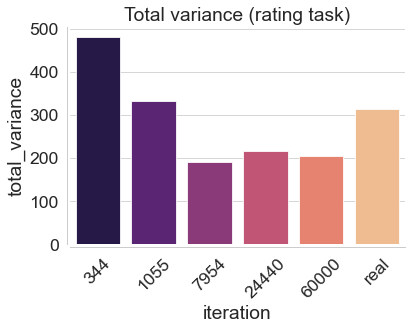

In [42]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    ax = sns.barplot(x='iteration', y='total_variance', palette="magma", data=df_pca)
    ax.tick_params(axis='x', rotation=45)
    plt.title(f'Total variance ({task} task)')
    sns.despine(ax=ax, offset=3)
    plt.savefig(figdir + f'{task}_PCA_pca_total_variance.png', dpi=200, bbox_inches='tight')

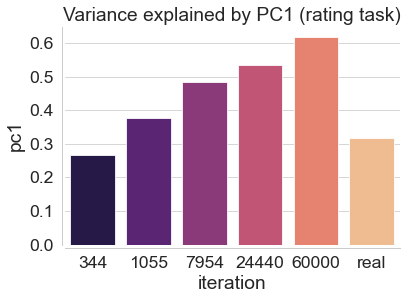

In [43]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")

    ax = sns.barplot(x='iteration', y='pc1', palette="magma", data=df_pca)
    plt.title(f'Variance explained by PC1 ({task} task)')
    sns.despine(ax=ax, offset=3)
    plt.savefig(figdir + f'{task}_PCA_pc1.png', dpi=200, bbox_inches='tight')

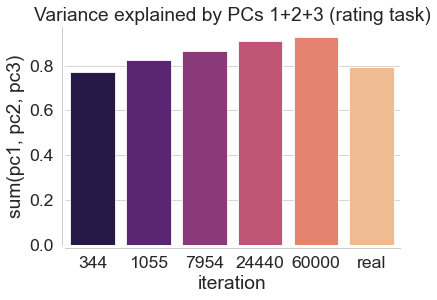

In [44]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
#     plt.figure(figsize=(11,4))
    ax = sns.barplot(x='iteration', y='pc123', palette="magma", data=df_pca)
    plt.ylabel('sum(pc1, pc2, pc3)')
    plt.title(f'Variance explained by PCs 1+2+3 ({task} task)')
    sns.despine(ax=ax, offset=3)
    plt.savefig(figdir + f'{task}_PCA_pc123.png', dpi=200, bbox_inches='tight')

### Plot eigenvalue spectrum

In [45]:
dfs = []
for key in keys:
    im = images[key].reshape((images[key].shape[0],-1))
    pca = PCA().fit(im)
    dfs.append(pd.DataFrame({'iteration':key, 'EV_number':range(len(pca.explained_variance_ratio_)), 'EV':pca.explained_variance_ratio_}))

df_ev = pd.concat(dfs, axis=0).reset_index()

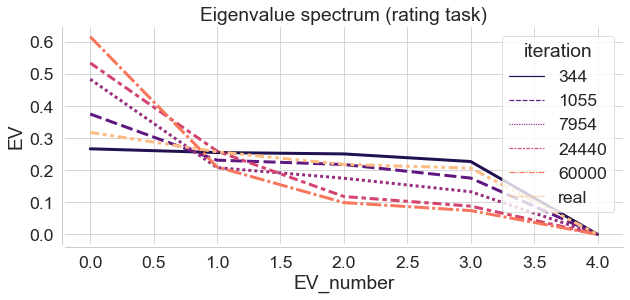

In [46]:
with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,4))
    plt.title(f'Eigenvalue spectrum ({task} task)')
    ax = sns.lineplot(x='EV_number', y='EV', hue='iteration',style='iteration', palette="magma", 
                      linewidth=3,
                      data=df_ev)
    sns.despine(ax=ax, offset=3)
#     plt.ylim(0,0.1)
    plt.savefig(figdir + f'{task}_PCA_normalized_EV_spectrum.png', dpi=200, bbox_inches='tight')